In [1]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet


In [40]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Input, Lambda
 
class ActorNetwork(tf.keras.Model):
    def __init__(self, input_didims, action_dim, action_bound):
        super(ActorNetwork, self).__init__()
        self.action_bound = action_bound
        self.fc1 = Dense(64, activation="relu", input_shape=input_dims, kernel_initializer="he_uniform")
        self.fc2 = Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.mu = Dense(action_dim, activation='tanh')
        self.std = Dense(action_dim, activation='softplus')
        self.mu_out = Lambda(lambda x: x * self.action_bound)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc3(x)
        mu = self.mu(x)
        mu = self.mu_out(mu)
        
        std = self.std(x)
        return mu, std                                                                                                                                               

In [41]:
class CriticNetwork(tf.keras.Model):
    def __init__(self, input_dims, action_dim=1):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(512, activation="relu", input_shape=input_dims, kernel_initializer="he_uniform")
        self.fc2 = Dense(256, activation="relu", kernel_initializer="he_uniform")
        self.fc2 = Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(1)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x  

In [114]:
from tensorflow.keras.optimizers import Adam

class PPOAgent:
    def __init__(self, input_dims, out_dims, gamma, alpha, beta, action_bound, std_bound): 
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        self.gamma = gamma
        self.alpha = alpha 
        self.beta = beta 
        self.action_bound = action_bound 
        self.std_bound = std_bound
        self.clip_ratio = 0.2
        
        self.actor_network = ActorNetwork(self.input_dims, self.out_dims, self.action_bound)
        self.critic_network = CriticNetwork(self.input_dims, 1)
        
        self.actor_network.compile(optimizer=Adam(learning_rate=self.alpha))
        self.critic_network.compile(optimizer=Adam(learning_rate=self.beta))
        
    def get_action(self, state):
        state = np.reshape(state, [1, self.input_dims[0]])
        mu, std = self.actor_network(state)
        action = np.random.normal(mu[0], std[0], size=self.out_dims)
        action = np.clip(action, -self.action_bound, self.action_bound)
        log_policy = self.log_pdf(mu, std, action)

        return log_policy, action
    
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / \
            var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)
    
    def save_models(self): 
        self.actor_network.save("models/" + "ppo_actor")
        self.critic_network.save("models/" + "ppo_critic")
        print("Saved the models successfully")
        
    def load_models(self):
        self.actor_network = tf.keras.models.load_model("models/" + "actor")
        self.critic_network = tf.keras.models.load_model("models/" + "critic")
        print("Loaded the models successfully")
        
    def actor_loss(self, log_old_policy, log_new_policy, actions, gaes):
        ratio = tf.exp(log_new_policy - tf.stop_gradient(log_old_policy))
        gaes = tf.stop_gradient(gaes)
        clipped_ratio = tf.clip_by_value(
            ratio, 1.0-self.clip_ratio, 1.0+self.clip_ratio)
        surrogate = -tf.minimum(ratio * gaes, clipped_ratio * gaes)
        return tf.reduce_mean(surrogate)
    
    def critic_loss(self, q_val, target_q_val): 
        mse = tf.keras.losses.MeanSquaredError()
        return mse(target_q_val, q_val)
    
    def learn(self, states, actions, gaes, log_old_policy, td_targets):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        gaes = tf.convert_to_tensor(gaes, dtype=tf.float32)
        log_old_policy = tf.convert_to_tensor(log_old_policy, dtype=tf.float32)
        td_targets = tf.convert_to_tensor(td_targets, dtype=tf.float32)
        with tf.GradientTape() as tape:
            mu, std = self.actor_network(states, training=True)
            log_new_policy = self.log_pdf(mu, std, actions)
            actor_loss = self.actor_loss(
                log_old_policy, log_new_policy, actions, gaes)
        
        actor_params = self.actor_network.trainable_variables
        actor_grads = tape.gradient(actor_loss, actor_params)
        self.actor_network.optimizer.apply_gradients(zip(actor_grads, actor_params))
        
        with tf.GradientTape() as tape:
            v_pred = self.critic_network(states, training=True)
            assert v_pred.shape == td_targets.shape
            critic_loss = self.critic_loss(v_pred, tf.stop_gradient(td_targets))
        
        critic_params = self.critic_network.trainable_variables
        critic_grads = tape.gradient(critic_loss, critic_params)
        self.critic_network.optimizer.apply_gradients(zip(critic_grads, critic_params))

In [115]:
import numpy as np 
import imageio


class RecordVideos: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no)
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []     

In [116]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, figure_file):

    x = [_ for _ in range(len(scores))]
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


def make_env(env_name): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env                                                                                                                                                        


In [117]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
                                      

In [118]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)
                    

In [128]:
import gymnasium as gym 


class Trainer: 
    def __init__(self, env, input_dims, out_dims, video_prefix, is_tg, 
                         noe, max_steps, record, alpha, beta, gamma, action_bound, 
                         std_bound, agent_update_interval, lmbda): 
        self.env = env
        self.noe = noe 
        self.max_steps = max_steps 
        self.input_dims = input_dims 
        self.out_dims = out_dims
        self.gamma = gamma 
        self.lmbda = lmbda
        self.agent_update_interval = agent_update_interval
        self.target_val = 190

        self.recorder = RecordVideos(video_prefix)
        self.is_tg = is_tg 
        self.record = record
        self.agent = PPOAgent(input_dims, out_dims, gamma, alpha, beta, action_bound, std_bound)
        
    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + self.gamma * forward_val - v_values[k]
            gae_cumulative = self.gamma * self.lmbda * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets
    
    def list_to_batch(self, list):
        batch = list[0]
        for elem in list[1:]:
            batch = np.append(batch, elem, axis=0)
        return batch

    def train(self): 

        ep_rewards = []
        avg_rewards = []
        best_reward = float("-inf")
        

        for episode in range(self.noe): 
            episodic_rewards = 0
            state_batch = []
            action_batch = []
            reward_batch = []
            old_policy_batch = []
            
            state, _ = self.env.reset()
            rewards = 0 

            if self.record and episode % 50 == 0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps):
                log_old_policy, action = self.agent.get_action(state)
                next_info = self.env.step(action)

                next_state, reward_prob, terminated, truncated, _ = next_info 
                done = terminated or truncated 
                episodic_rewards += reward_prob
                
                state = np.reshape(state, [1, self.input_dims[0]])
                action = np.reshape(action, [1, self.out_dims])
                next_state = np.reshape(next_state, [1, self.input_dims[0]])
                reward = np.reshape(reward_prob, [1, 1])
                log_old_policy = np.reshape(log_old_policy, [1, 1])
                
                state_batch.append(state)
                action_batch.append(action)
                reward_batch.append(reward)
                old_policy_batch.append(log_old_policy)
                
                if len(state_batch) >= self.agent_update_interval or done:
                    states = self.list_to_batch(state_batch)
                    actions = self.list_to_batch(action_batch)
                    rewards = self.list_to_batch(reward_batch)
                    old_policys = self.list_to_batch(old_policy_batch)

                    v_values = self.agent.critic_network(states)
                    next_v_value = self.agent.critic_network(next_state)

                    gaes, td_targets = self.gae_target(
                        rewards, v_values, next_v_value, done)
                    
                #    print(gaes, 'gaes')
                    for _ in range(3): 
                        self.agent.learn(states, actions, gaes, old_policys, td_targets)
                    state_batch = []
                    action_batch = []
                    old_policy_batch = []
                    reward_batch = []

                state = next_state

                if self.record and episode % 50 == 0:
                    img = self.env.render()
                    self.recorder.add_image(img)

                if done: 
                    break 

            if self.record and episode % 50 == 0:
                self.recorder.save(episode)

            ep_rewards.append(episodic_rewards)
            avg_reward = np.mean(ep_rewards[-100:])
            avg_rewards.append(avg_reward)
            print(f"Episode: {episode} Reward: {episodic_rewards} Best Score: {best_reward}, Average Reward: {avg_reward}")
            
            if self.target_val <= avg_reward:
                break
            
            if episodic_rewards > best_reward: 
                self.agent.save_models()
                best_reward = episodic_rewards

        return ep_rewards, avg_rewards


2
Episode: 0 Reward: -813.5048244100974 Best Score: -inf, Average Reward: -813.5048244100974
Saved the models successfully
Episode: 1 Reward: -679.4817479827332 Best Score: -813.5048244100974, Average Reward: -746.4932861964153
Saved the models successfully
Episode: 2 Reward: -414.36301901132776 Best Score: -679.4817479827332, Average Reward: -635.7831971347194
Saved the models successfully
Episode: 3 Reward: -528.4883164702911 Best Score: -414.36301901132776, Average Reward: -608.9594769686123
Episode: 4 Reward: -635.2467533003182 Best Score: -414.36301901132776, Average Reward: -614.2169322349534
Episode: 5 Reward: -433.61795725561996 Best Score: -414.36301901132776, Average Reward: -584.1171030717312
Episode: 6 Reward: -497.39916254093663 Best Score: -414.36301901132776, Average Reward: -571.7288258530463
Episode: 7 Reward: -736.5119967984092 Best Score: -414.36301901132776, Average Reward: -592.3267222212166
Episode: 8 Reward: -494.6370837395104 Best Score: -414.36301901132776, Ave

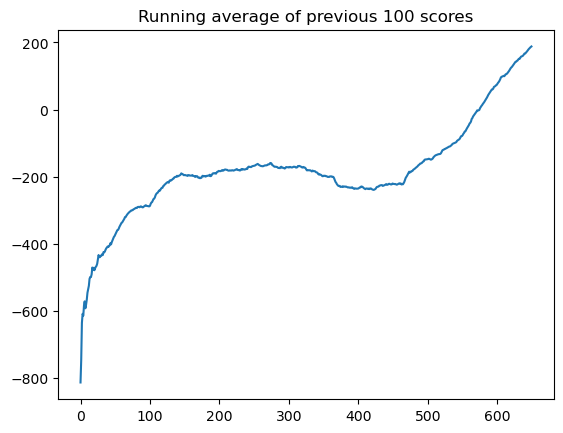

In [130]:
import numpy as np 
import gymnasium as gym
import pickle 

env = make_env("LunarLanderContinuous-v2")
out_dims = env.action_space.shape[0]
action_bound = env.action_space.high[0]
input_dims = env.observation_space.shape
std_bound = [1e-2, 1.0]
print(out_dims)
noe = 1000 
max_steps = int(1e6)
video_prefix = "ppo"
is_tg = True 
record = True
alpha = 0.0001
beta = 0.001
gamma = 0.99
lmbda = 0.94
agent_update_interval = 10

if __name__ == "__main__": 
  
    trainer = Trainer(env, input_dims, out_dims, video_prefix, is_tg, 
                         noe, max_steps, record, alpha, beta, gamma, action_bound, 
                         std_bound, agent_update_interval, lmbda)
    ep_rewards, avg_rewards = trainer.train()

    with open("ppo_episode_rewards.obj", "wb") as f: 
        pickle.dump(ep_rewards, f)

    with open("ppo_avg_rewards.obj", "wb") as f: 
        pickle.dump(avg_rewards, f)
    
    plot_learning_curve(ep_rewards, "ppo.png")   

In [148]:
import random 
import imageio
import tensorflow as tf 

class Eval: 

    def __init__(self, env, model_path, video_prefix, number_of_episode=50):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        self.recorder = RecordVideos(video_prefix, 'test_videos/', 15)
        self.number_of_episode = number_of_episode
        self.input_dims = self.env.observation_space.shape[0]
        self.out_dims = self.env.action_space.shape[0]
        self.action_bound = self.env.action_space.high[0]
        self.std_bound = [1e-2, 1.0]
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state, _ = env.reset(seed=random.randint(0,500))
            if episode % 10 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                state = tf.reshape(state, (1, self.input_dims))
                _, action =  self.get_action(self.model, state)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 10 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
       #     self.recorder.save(episode) if episode % 10 == 0 else None
        
        return rewards, steps
    
    def get_action(self, model, state):
        state = np.reshape(state, [1, self.input_dims])
        mu, std = self.model(state)
        action = np.random.normal(mu[0], std[0], size=self.out_dims)
        action = np.clip(action, -self.action_bound, self.action_bound)
        log_policy = self.log_pdf(mu, std, action)
        return log_policy, action
        
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / \
            var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

model_path = "models/ppo_actor/"
evaluator = Eval(env, model_path, "ppo", 10)
rewards, steps = evaluator.test()

print(rewards, steps)                                                                                                                                                        


[224.64679884156186, 186.56280181703494, 217.3517142200272, 260.19256223652087, 278.58496519804703, -33.10719676052983, 257.0548918389763, 236.67436608664764, -123.81650605526511, 279.1621386979937] [484, 596, 610, 377, 437, 338, 564, 489, 434, 486]
